# Optical character recognition using RNNs

OCR allows us to recognise text inside images (scanned docs and photos) and convert it to machine-readable text.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import os
import gzip
import csv

In [3]:
import numpy as np
import tensorflow as tf

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [5]:
from six.moves import urllib

In [6]:
print(np.__version__)
print(tf.__version__)

1.12.1
1.0.0


In [7]:
URL_PATH = 'http://ai.stanford.edu/~btaskar/ocr/letter.data.gz'
DOWNLOADED_FILENAME = 'letter.data.gz'

def download_data():
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(URL_PATH, DOWNLOADED_FILENAME)
    
    print('Found and verified file from this path: ', URL_PATH)
    print('Downloaded file: ', DOWNLOADED_FILENAME)

In [8]:
download_data()

Found and verified file from this path:  http://ai.stanford.edu/~btaskar/ocr/letter.data.gz
Downloaded file:  letter.data.gz


## MIT OCR dataset
* each word is a sequence of images - an image represents one character
* 6800 words, 14 characters in length 
* character image = 16 x 8
* All uppercase characters are filtered out
* One line for each letter of each word
* Each letter(line) has an id
* Each line has a link to the next letter's id
* Line includes 128 fields for pixels
* All fields are tab delimited

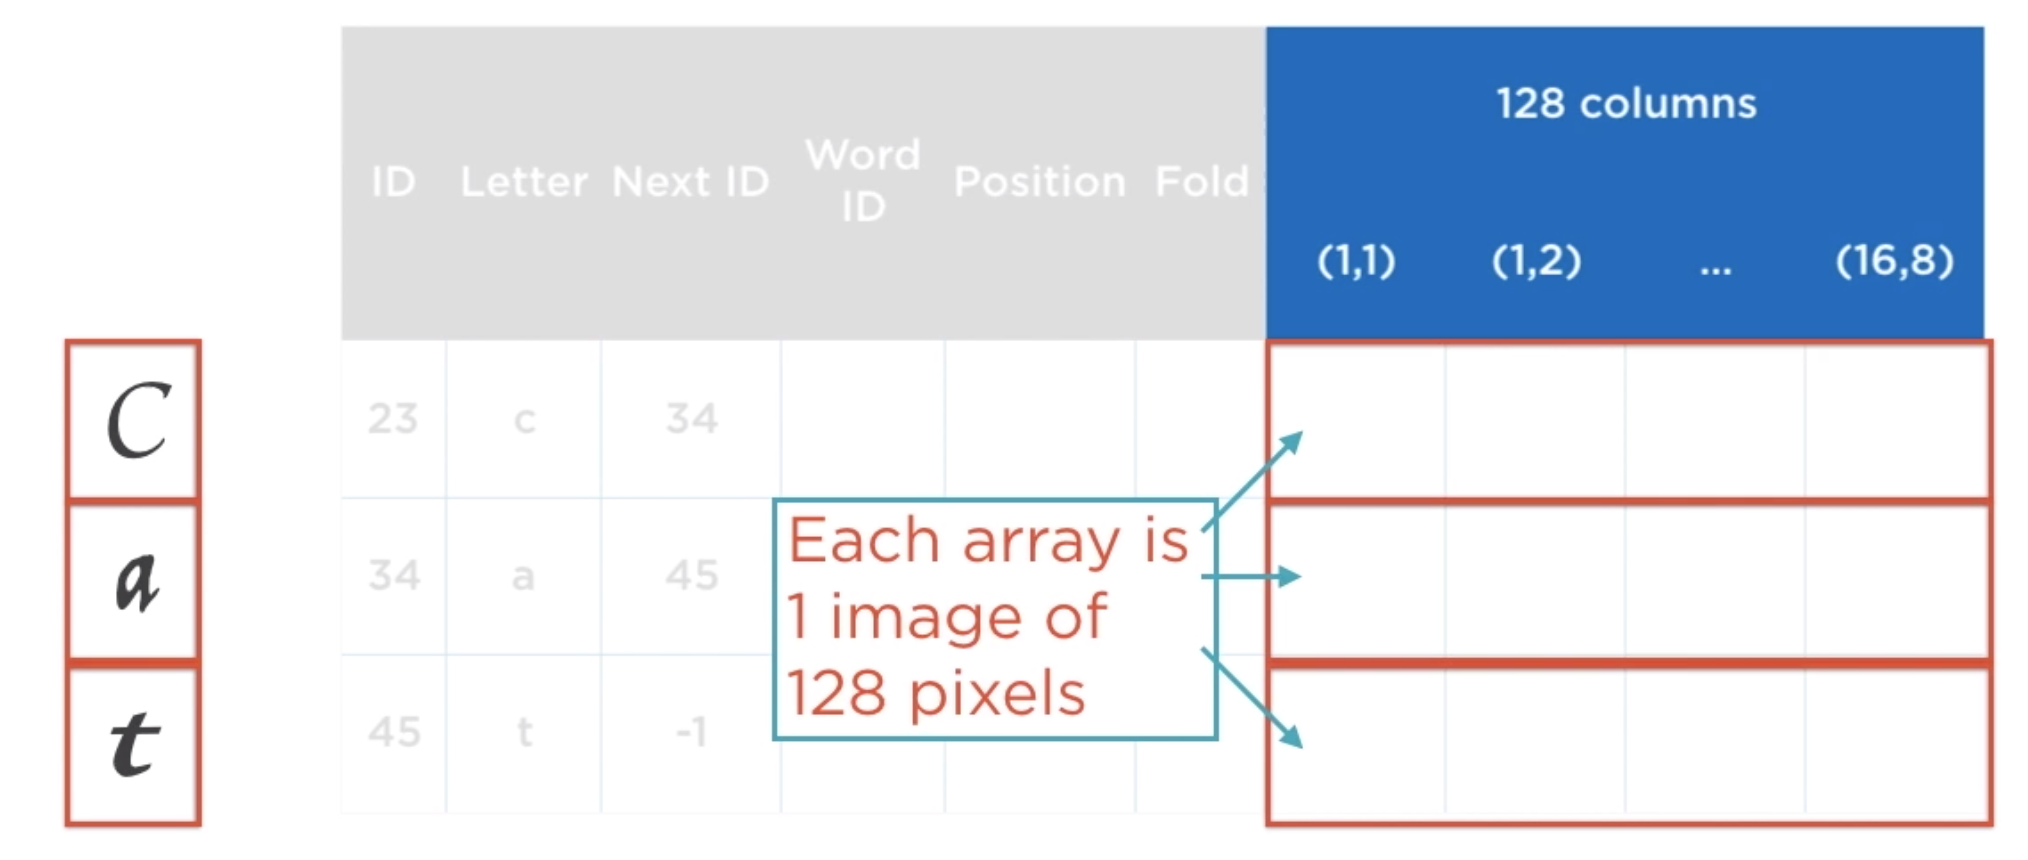

Thw Word ID and the Position is not used in the dataset for our investigation. The Word ID represents a unique ID for the word and the Position refers to the position of the character in the word. Similarly Fold is also ignored - it is a value from 0-9 and is useful to build a model for cross-validation. Finally and more crucially we arrive at the 128 fields - each array is one image of 128 pixels with it's elements restrained to be 0/1. The Letter field is represented as one-hot encoded labels.

In [9]:
def read_lines():
    with gzip.open(DOWNLOADED_FILENAME, 'rt') as f:
        reader = csv.reader(f, delimiter='\t')
        lines = list(reader)

        return lines

In [10]:
lines = read_lines()

### Format of every line

* id
* letter
* next_id
* word_id
* position
* fold
* 16x8 columns of pixel values

*next_id = -1 when the current word has ended and the next character is the start of a new word*

In [11]:
lines[1][:20]

['2',
 'm',
 '3',
 '1',
 '2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0']

In [12]:
len(lines)

52152

In [13]:
lines[1][:15]

['2', 'm', '3', '1', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

In [14]:
def get_features_labels(lines):
    lines = sorted(lines, key=lambda x: int(x[0])) 
    #sort on the character id, so character sequences which make up a word are maintained
    
    data, target = [], []
    # data = input sequences of the images that make up the word
    #target = word as a sequence of actual characters
    
    next_id = -1
    
    word = [] # characters which make up a word
    word_pixels = [] # images of those characters

    for line in lines:
         # The index for the next_id column
        next_id = int(line[2])

        # An image for a single character, reshaped
        pixels = np.array([int(x) for x in line[6:134]])
        pixels = pixels.reshape((16, 8))
        
        # Word pixels are a list of 16x8 images which form a single word
        word_pixels.append(pixels)
        
        # Append together the characters which make up a word
        word.append(line[1])
        
        if next_id == -1: # before moving onto the next word - append the current word to the data and target
            data.append(word_pixels)
            target.append(word)

            word = []
            word_pixels = []


    return data, target

In [15]:
data, target = get_features_labels(lines)

#### The total number of words in our dataset

In [16]:
len(data), len(target)

(6877, 6877)

#### All words lengths should be the same

* Get every word to be the same length as the longest word in our dataset
* Pad the words with empty characters

In [17]:
def pad_features_labels(data, target):    
    max_length = max(len(x) for x in target)
    
    # Set up image representations for the empty string (all pixels set to 0)
    padding = np.zeros((16, 8))

    # Pad the image data with the empty string images
    data = [x + ([padding] * (max_length - len(x))) for x in data]
    
    # Pad the words with empty string characters
    target = [x + ([''] * (max_length - len(x))) for x in target]
    
    return np.array(data), np.array(target)

In [18]:
padded_data, padded_target = pad_features_labels(data, target)

In [19]:
padded_data[1,1] # 1 character image 16 x 8 pixels

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [20]:
padded_target[:10]

array([['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', '']], 
      dtype='<U1')

In [21]:
padded_target[200:210]

array([['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', '']], 
      dtype='<U1')

#### The length of each sequence

We've padded all words so that their lengths are all equal to the length of the longest word

In [22]:
word_length = len(padded_target[0])

In [23]:
word_length

14

#### Tensor shape

* 6877 words
* Each word padded to have 14 characters
* Each character represented by 16x8 image

In [24]:
padded_data.shape

(6877, 14, 16, 8)

In [25]:
padded_data.shape[:2] + (-1,)

(6877, 14, -1)

In [26]:
reshaped_data = padded_data.reshape(padded_data.shape[:2] + (-1,))

#### Reshape the data so the image is a 1-D array of pixels

In [27]:
reshaped_data.shape #flattens the 16x8 = 128

(6877, 14, 128)

#### Tensor shape

* 6877 words
* Each an array with 14 characters (padded with empty strings as needed)

In [28]:
padded_target.shape

(6877, 14)

#### One-hot representation

* Each character has a feature vector of 26 (only lower case characters)

In [29]:
padded_target.shape + (26,)

(6877, 14, 26)

In [30]:
one_hot_target = np.zeros(padded_target.shape + (26,))

### Numpy.ndenumerate is a way to get all indices needed to access elements of a matrix
<pre>
a = numpy.array([[1,2],[3,4],[5,6]])
for (x,y), value in numpy.ndenumerate(a):
  print x,y 
</pre>
 
0 0 <br>
0 1 <br>
1 0 <br>
1 1 <br>
2 0 <br>
2 1 <br>

Using this in our padded_target allows us to iterate through every word and every character in every word. The $\texttt{one_hot_target[index]}$ accessed the word , $\texttt{one_hot_target[ord(letter) - ord('a')]}$ - this finds the index of the character represented by letter.

In [31]:
for index, letter in np.ndenumerate(padded_target):
    if letter:
        one_hot_target[index][ord(letter) - ord('a')] = 1

#### One-hot representation of the letter 'o'

* The letter 'o' represented by a 1 at the 14th index 
* Index positions start at 0

In [32]:
one_hot_target[0][0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [33]:
shuffled_indices = np.random.permutation(len(reshaped_data))

shuffled_data = reshaped_data[shuffled_indices]
shuffled_target = one_hot_target[shuffled_indices]

#### Split into training and test data

In [34]:
split = int(0.66 * len(shuffled_data))

train_data = shuffled_data[:split]
train_target = shuffled_target[:split]

test_data = shuffled_data[split:]
test_target = shuffled_target[split:]

In [35]:
train_data.shape

(4538, 14, 128)

Input tensor = [batch_size, 14, 128] 

batch_size = no. of words fed in each batch
14 = the length of every word which also equals the length of the RNN (no. of layers) - it is also the no. of time instances for which we have input data.
128 = no. of pixels

In [36]:
_, num_steps, num_inputs = train_data.shape

In [37]:
train_target.shape

(4538, 14, 26)

In [38]:
num_classes = train_target.shape[2]

In [39]:
tf.reset_default_graph()

In [40]:
X = tf.placeholder(tf.float64, [None, num_steps, num_inputs])

y = tf.placeholder(tf.float64, [None, num_steps, num_classes])

#### Sequence length calculation

*['How', 'are', 'you', 'doing'] ==> [14, 14, 14, 14] ==> [3, 3, 3, 5]*
 
 The actual length of each word (without the padding) in the input batch

In [41]:
# All real characters will have a max value of 1, padded characters will be represented by 0s
used = tf.sign(tf.reduce_max(tf.abs(X), reduction_indices=2))

# Sum up the number of real characters for each word
length = tf.reduce_sum(used, reduction_indices=1)
sequence_length = tf.cast(length, tf.int32)

In [42]:
sequence_length

<tf.Tensor 'Cast:0' shape=(?,) dtype=int32>

#### RNN for training and prediction

In [43]:
num_neurons = 300 #hyper parameter

In [48]:
cell = tf.contrib.rnn.GRUCell(num_neurons)

#### *sequence_length* is the length of the valid input for each batch

Included to improve accuracy and not for performance

The output tuple of the RNN has the predicted output and the last internal state of the RNN.

In [49]:
output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float64, sequence_length=sequence_length)

In [50]:
output.shape

TensorShape([Dimension(None), Dimension(14), Dimension(300)])

#### Shared softmax layer

In [51]:
weight = tf.Variable(tf.truncated_normal([num_neurons, num_classes], stddev=0.01, dtype=tf.float64))

In [52]:
bias = tf.Variable(tf.constant(0.1, shape=[num_classes], dtype=tf.float64))

In [53]:
flattened_output = tf.reshape(output, [-1, num_neurons])

In [54]:
flattened_output

<tf.Tensor 'Reshape:0' shape=(?, 300) dtype=float64>

In [55]:
logits = tf.matmul(flattened_output, weight) + bias

In [56]:
logits_reshaped = tf.reshape(logits, [-1, num_steps, num_classes]) #reshape to the target dims

#### Cost calculation

cross entropy = difference in the probability distribution between the actual y labels and the predicted y labels - similar distributions will have lower cross entropy. Hence why we wish minimise the cross entropy.

In [59]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)

In [60]:
loss = tf.reduce_mean(cross_entropy)

#### Error calculation

* For every word calculate how many of the characters we predicted correctly
* Use the mask to not consider (leave out) the padded characters on which our prediction was wrong
* Find the fraction of each word where we made mistakes in our character prediction
* Find the average fraction of each word that were mistakes

In [61]:
mistakes = tf.not_equal(
            tf.argmax(y, 2), tf.argmax(logits_reshaped, 2))
mistakes = tf.cast(mistakes, tf.float64)
mask = tf.sign(tf.reduce_max(tf.abs(y), reduction_indices=2))
mistakes *= mask

In [62]:
mistakes = tf.reduce_sum(mistakes, reduction_indices=1)
mistakes /= tf.cast(sequence_length, tf.float64)

In [63]:
error = tf.reduce_mean(mistakes)

#### Optimizer

In [64]:
optimizer = tf.train.RMSPropOptimizer(0.002)

In [65]:
gradient = optimizer.compute_gradients(loss)

In [66]:
optimize = optimizer.apply_gradients(gradient)

In [67]:
def batched(data, target, batch_size):
    epoch = 0
    offset = 0
    while True:
        old_offset = offset
        offset = (offset + batch_size) % (target.shape[0] - batch_size)

        # Offset wrapped around to the beginning so new epoch
        if offset < old_offset:
            # New epoch, need to shuffle data
            shuffled_indices = np.random.permutation(len(data))
            
            data = data[shuffled_indices]
            target = target[shuffled_indices]

            epoch += 1

        batch_data = data[offset:(offset + batch_size), :]
        
        batch_target = target[offset:(offset + batch_size), :]

        yield batch_data, batch_target, epoch

In [68]:
batch_size = 20
batches = batched(train_data, train_target, batch_size)

In [69]:
epochs = 5

In [70]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    for index, batch in enumerate(batches):
        batch_data = batch[0]
        batch_target = batch[1]
    
        epoch = batch[2]

        if epoch >= epochs:
            break
        
        feed = {X: batch_data, y: batch_target}
        y_pred, train_error, _ = sess.run([logits_reshaped, error, optimize], feed)
        
        print('{}: {:3.6f}%'.format(index + 1, 100 * train_error))
#         print(batch_target)
#         print(y_pred)

    test_feed = {X: test_data, y: test_target}
    test_error, _ = sess.run([error, optimize], test_feed)
    
    print('Test error: {:3.6f}%'.format(100 * test_error))

1: 96.646825%
2: 99.444444%
3: 96.056999%
4: 98.105159%
5: 97.516484%
6: 99.375000%
7: 96.580808%
8: 99.000000%
9: 96.309524%
10: 97.619048%
11: 96.259921%
12: 99.615385%
13: 94.515873%
14: 97.188312%
15: 96.275613%
16: 94.737734%
17: 93.559774%
18: 96.381383%
19: 97.416667%
20: 99.000000%
21: 100.000000%
22: 95.138528%
23: 95.114719%
24: 93.343809%
25: 97.938312%
26: 95.924908%
27: 93.654401%
28: 95.798701%
29: 96.805556%
30: 91.640693%
31: 90.836053%
32: 94.561328%
33: 94.202020%
34: 94.866883%
35: 91.239011%
36: 91.394425%
37: 94.613095%
38: 91.826840%
39: 90.386905%
40: 94.105159%
41: 90.327381%
42: 91.963037%
43: 86.920940%
44: 92.532246%
45: 87.860029%
46: 90.742369%
47: 89.285714%
48: 89.382881%
49: 91.097222%
50: 92.753788%
51: 86.304779%
52: 92.416667%
53: 88.138889%
54: 87.068376%
55: 87.243687%
56: 83.662698%
57: 91.600830%
58: 90.241883%
59: 86.355103%
60: 91.119658%
61: 91.957875%
62: 86.950952%
63: 86.059288%
64: 84.990079%
65: 80.583333%
66: 86.663309%
67: 89.426587%
68:

526: 6.597222%
527: 2.852564%
528: 6.992063%
529: 9.581530%
530: 7.438187%
531: 12.831197%
532: 3.862665%
533: 17.031136%
534: 10.121212%
535: 13.896520%
536: 7.557720%
537: 6.983877%
538: 5.833333%
539: 9.674964%
540: 7.755952%
541: 14.225885%
542: 7.370421%
543: 6.783425%
544: 11.741758%
545: 9.117063%
546: 4.419192%
547: 5.954545%
548: 11.696429%
549: 10.991453%
550: 12.196970%
551: 7.659799%
552: 5.138889%
553: 10.458333%
554: 7.454365%
555: 11.265568%
556: 7.248196%
557: 6.866453%
558: 9.464286%
559: 4.068182%
560: 7.343490%
561: 7.289377%
562: 10.469322%
563: 11.597222%
564: 10.357143%
565: 12.222222%
566: 11.617063%
567: 6.625000%
568: 12.706349%
569: 9.771825%
570: 9.166667%
571: 6.386905%
572: 7.983516%
573: 3.888889%
574: 8.388889%
575: 4.523810%
576: 6.196970%
577: 4.450397%
578: 10.238095%
579: 5.467949%
580: 7.242605%
581: 12.285562%
582: 13.998016%
583: 5.208333%
584: 6.432234%
585: 2.380952%
586: 5.435897%
587: 4.107143%
588: 14.172619%
589: 7.517857%
590: 15.927961%
591

1066: 0.714286%
1067: 6.277778%
1068: 4.432234%
1069: 5.384615%
1070: 2.708333%
1071: 3.936508%
1072: 1.500000%
1073: 2.986111%
1074: 2.896825%
1075: 1.894841%
1076: 3.231838%
1077: 8.825272%
1078: 2.337662%
1079: 7.416667%
1080: 5.833333%
1081: 4.095238%
1082: 7.111111%
1083: 2.428571%
1084: 4.880952%
1085: 4.109127%
1086: 1.153846%
1087: 5.440171%
1088: 5.380952%
1089: 6.547619%
1090: 3.005952%
1091: 2.190476%
1092: 0.454545%
1093: 4.843434%
1094: 8.000000%
1095: 3.770202%
1096: 5.357143%
1097: 2.736111%
1098: 8.666667%
1099: 0.912698%
1100: 1.190476%
1101: 7.902778%
1102: 9.958333%
1103: 0.500000%
1104: 3.787879%
1105: 5.173993%
1106: 4.620726%
1107: 4.583333%
1108: 2.478355%
1109: 2.714286%
1110: 2.103175%
1111: 0.833333%
1112: 4.444444%
1113: 6.333333%
1114: 1.769841%
1115: 3.333333%
1116: 4.069444%
1117: 3.383117%
1118: 2.916667%
1119: 3.537088%
1120: 9.717949%
1121: 4.616453%
1122: 3.717949%
1123: 3.277778%
1124: 1.746032%
1125: 3.579365%
1126: 4.047619%
1127: 3.888889%
1128: 3.